### Benchmark for RF w/Missing Value support

#### Sys stats

In [1]:
# To keep track of the machine this script is run in
import IPython; import sklearn, numpy as np, scipy; from ast import literal_eval
CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
!echo "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)"; 
!echo -n "sklearn $SKVERSION "
!echo -n "in branch \""
!echo -n "$(git --git-dir "$SCIKIT_LEARN_PATH"/.git rev-parse --abbrev-ref HEAD)\", "
!echo "($(git --git-dir "$SCIKIT_LEARN_PATH"/.git log --pretty=format:'%h-%s' -n 1))"
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION - IPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

At host "tsilinuxd98" with 8 cores. Current Dir - /cal/homes/vrajagopalan/raghav/miss_val_bench
sklearn 0.18.dev0 in branch "missing_values_rf", (ba37a72-STASH [ci skip] [doc skip])
np v1.10.4 - scipy v0.17.0 - IPython v4.0.3 - Python 2.7.11 :: Anaconda 2.5.0 (64-bit)
@ /tsi/doctorants/raghav/anaconda/anaconda3/envs/python2/bin/python


#### Imports

In [13]:
from timeit import default_timer as timer

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Imputer

from sklearn.datasets import *

#### The Setup

In [87]:
# SOME PARAMETERS

plt.rcParams['figure.figsize'][:] = [15, 15]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'


# Use all the cores
n_jobs = -1
n_estimators = 50
cv = StratifiedShuffleSplit(n_iter=3, test_size=0.1,
                            random_state=42)


# THE ESTIMATORS
# RF handling missing values like a boss
rf_missing_val = RandomForestClassifier(n_estimators=n_estimators,
                                        missing_values='NaN',
                                        n_jobs=n_jobs,
                                        random_state=42)

# imputation(mean) ---> RF
rf_with_impute = Pipeline([('imp', Imputer(strategy='mean',
                                           missing_values='NaN')), 
                           ('rf', RandomForestClassifier(
                                      n_estimators=n_estimators,
                                      missing_values=None,
                                      n_jobs=n_jobs,
                                      random_state=42))])

# imputation(mean) ---> DummyClassifier
dummy_with_impute = Pipeline([('imp', Imputer(strategy='mean',
                                              missing_values='NaN')), 
                              ('dum', DummyClassifier())])

# imputation(mean) ---> LogisticRegressionCV
logit_with_impute = Pipeline([('imp', Imputer(strategy='mean',
                                              missing_values='NaN')), 
                              ('log', LogisticRegressionCV(
                                          n_jobs=n_jobs,
                                          random_state=42))])

#### The dataset

In [28]:
#dataset = load_

#data, target = dataset.data, dataset.target
data, target = make_classification(n_samples=10000, n_features=4,
                                   n_informative=2, n_redundant=2,
                                   n_classes=2,
                                   n_clusters_per_class=2,
                                   random_state=42)

# densify
if scipy.sparse.issparse(data):
    print "Data is sparse! Attempting densification"
    data = data.toarray()

# Initially we have no missing
print "%0.2f %% of values missing" % (np.mean(np.isnan(target))*100)

# Subsample the data
# data, target = data[::5], target[::5]

print "The shape of the entire dataset - %s; Target - %s" % (str(data.shape), str(target.shape))
print "The shape of the subsampled dataset - %s" % str(data.shape)

unique_targets = np.unique(target)
print "Classes - ", unique_targets
print "Class counts - ", np.bincount(target)[-len(unique_targets):]
print

0.00 % of values missing
The shape of the entire dataset - (10000, 4); Target - (10000,)
The shape of the subsampled dataset - (10000, 4)
Classes -  [0 1]
Class counts -  [5000 5000]



In [32]:
print ('The baseline score without missing is %0.8f'
       % cross_val_score(rf_missing_val, data, target).mean())

The baseline score without missing is 0.93379877


#### The Benchmark

In [33]:
missing_mask = np.zeros(data.shape, dtype=bool)
labels = None

rf_with_imp_scores = []
dummy_with_imp_scores = []
logit_with_imp_scores = []
rf_miss_val_scores = []

rf_with_imp_times = []
dummy_with_imp_times = []
logit_with_imp_times = []
rf_miss_val_times = []

missing_fractions = np.arange(0, 0.50, 0.01)
n_missing_fractions = len(missing_fractions)

label_correlations = (0, 1)

for label_correlation in label_correlations:
    print "Labels correlated with - %s" % str(labels)
    print "Label correlation - %0.2f" % label_correlation
    print
    
    X, y = data.copy(), target.copy()
    missing_mask = np.zeros(X.shape, dtype=bool)
    labels = [1]
        
    for missing_fraction in missing_fractions:
        print
        print "-------------------------------------------------------"
        
        X, y, missing_mask, label = drop_values(
            X, y,
            missing_mask=missing_mask,
            missing_fraction=missing_fraction,
            # The MCAR-ness should not change
            label_correlation=label_correlation,
            # Persist the correlation with the same label
            labels=labels,
            return_missing_mask=True,
            return_labels=True,
            )
        
        print ("Missing fraction - (Expected - %0.4f, Actual - %0.4f)"
               % (missing_fraction, missing_mask.mean()))
        print ("Fraction of samples missing when label == %d - %0.4f"
               % (labels[0], missing_mask[y==labels[0]].mean()))
        print ("Fraction of samples missing when label != %d - %0.4f"
               % (labels[0], missing_mask[y!=labels[0]].mean()))
        
        start = timer()
        rf_miss_val_score = cross_val_score(rf_missing_val, X, y, cv=cv)
        end = timer()
        rf_miss_val_time = end - start
        rf_miss_val_scores.append(rf_miss_val_score.mean())
        rf_miss_val_times.append(rf_miss_val_time)
        print ("RF w/MV completed in %0.2f s with a mean score of %0.4f"
               % (rf_miss_val_time, rf_miss_val_scores[-1]))
        
        
        start = timer()
        rf_with_imp_score = cross_val_score(rf_with_impute, X, y, cv=cv)
        end = timer()
        rf_with_imp_time = end - start
        rf_with_imp_scores.append(rf_with_imp_score.mean())
        rf_with_imp_times.append(rf_with_imp_time)
        print ("IMP + RF completed in %0.2f s with a mean score of %0.4f"
               % (rf_with_imp_time, rf_with_imp_scores[-1]))

        start = timer()
        logit_with_imp_score = cross_val_score(logit_with_impute, X, y, cv=cv)
        end = timer()
        logit_with_imp_time = end - start
        logit_with_imp_scores.append(logit_with_imp_score.mean())
        logit_with_imp_times.append(logit_with_imp_time)
        print ("IMP + Logit completed in %0.2f s with a mean score of %0.4f"
               % (logit_with_imp_time, logit_with_imp_scores[-1]))
        
        start = timer()
        dummy_with_imp_score = cross_val_score(dummy_with_impute, X, y, cv=cv)
        end = timer()
        dummy_with_imp_time = end - start
        dummy_with_imp_scores.append(dummy_with_imp_score.mean())
        dummy_with_imp_times.append(dummy_with_imp_time)
        print ("IMP + Dummy completed in %0.2f s with a mean score of %0.4f"
               % (dummy_with_imp_time, dummy_with_imp_scores[-1]))
        
        print "-------------------------------------------------------"
        print

rf_miss_val_scores = np.array(rf_miss_val_scores)
rf_miss_val_times = np.array(rf_miss_val_times)
rf_with_imp_scores = np.array(rf_with_imp_scores)
rf_with_imp_times = np.array(rf_with_imp_times)
logit_with_imp_scores = np.array(logit_with_imp_scores)
logit_with_imp_times = np.array(logit_with_imp_times)
dummy_with_imp_scores = np.array(dummy_with_imp_scores)
dummy_with_imp_times = np.array(dummy_with_imp_times)

Labels correlated with - None
Label correlation - 0.00


-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/0
Missing fraction - (Expected - 0.0000, Actual - 0.0000)
Fraction of samples missing when label == 1 - 0.0000
Fraction of samples missing when label != 1 - 0.0000
RF w/MV completed in 1.31 s with a mean score of 0.9360
IMP + RF completed in 1.36 s with a mean score of 0.9360
IMP + Logit completed in 1.45 s with a mean score of 0.8930
IMP + Dummy completed in 0.04 s with a mean score of 0.4933
-------------------------------------------------------


-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/400
Missing fraction - (Expected - 0.0100, Actual - 0.0100)
Fraction of samples missing when label == 1 - 0.0099
Fraction of samples missing when label != 1 - 0.0101
RF w/MV completed in 1.37 s with a mean score of 0.9353
IMP + RF completed in 1.40 s w

Labels correlated with - [1]
Label correlation - 0.00

Plotting the benchmark scores and times when label_correlation is 0.00. n_estimators=50


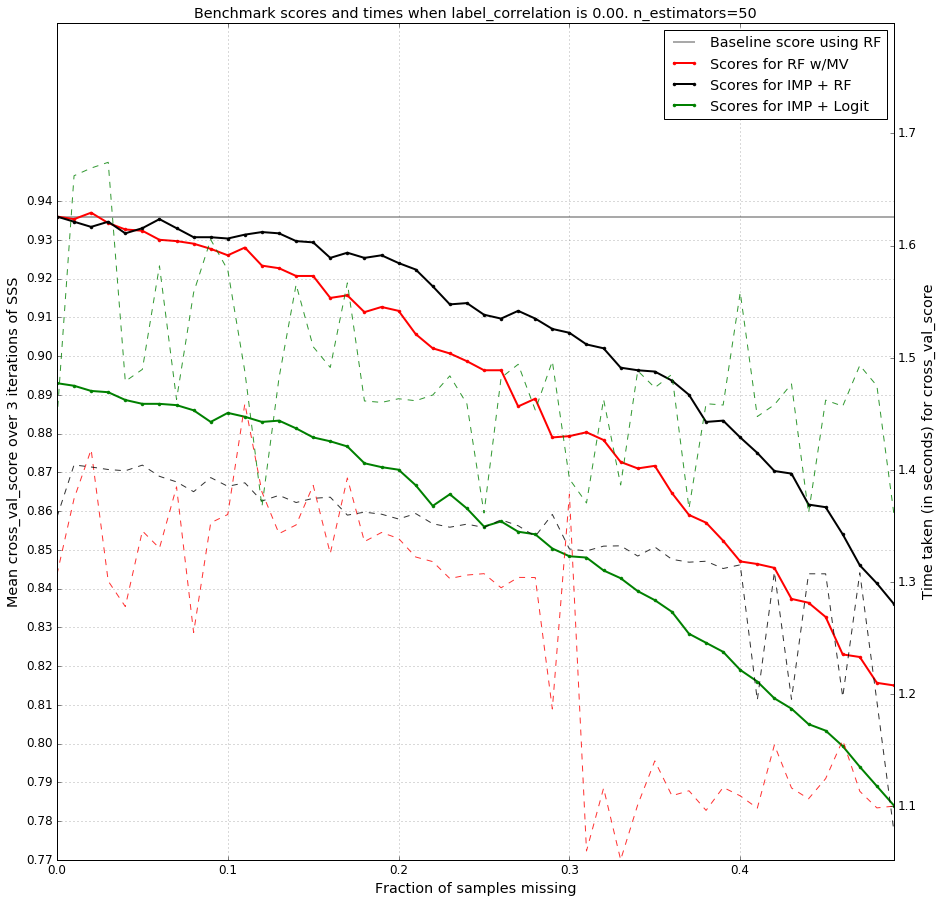

Label correlation - 1.00

Plotting the benchmark scores and times when label_correlation is 1.00. n_estimators=50


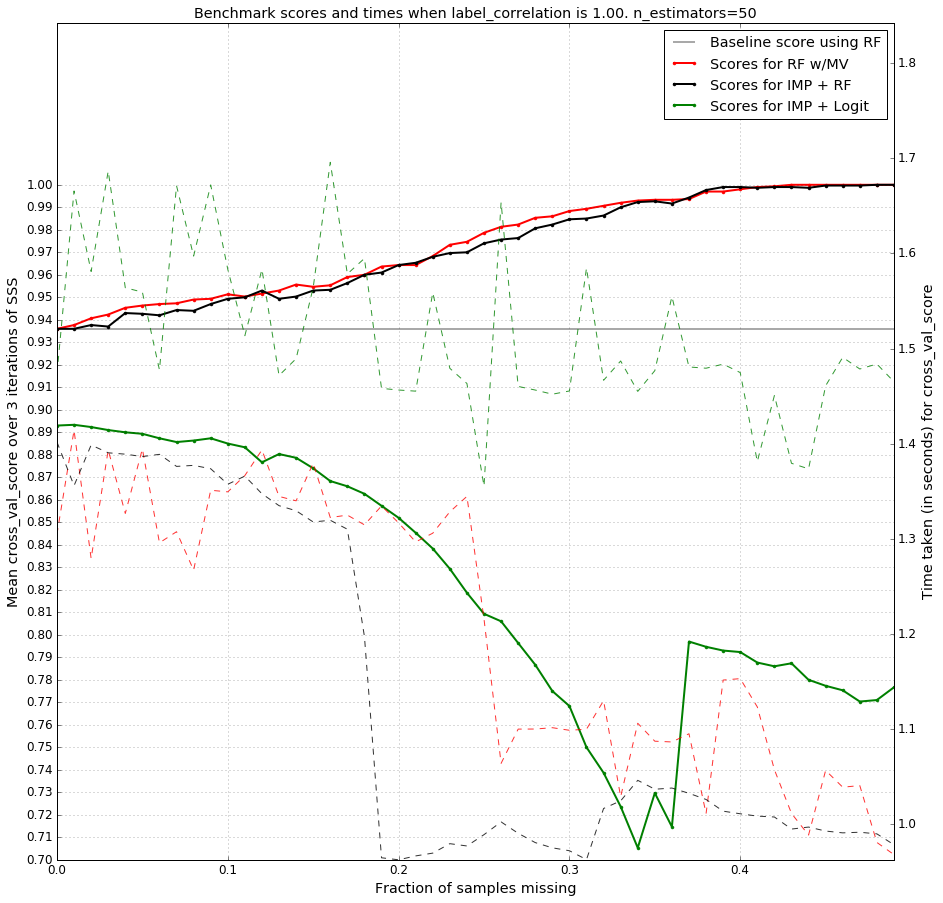

In [104]:
# Plot the scores and times
index = 0
if label_correlation != 0:
        print "Labels correlated with - %s" % str(labels)

# For the score plot
plot_labels = ['Scores for RF w/MV',
               'Scores for IMP + RF',
               'Scores for IMP + Logit',
               'Scores for IMP + Dummy']
plot_colors = ['r', 'k', 'g', 'y']
plot_styles = ['.-', '.-', '.-', '.-']

# For the time plot
plot2_labels = ['Times for RF w/MV',
                'Times for IMP + RF',
                'Times for IMP + Logit',
                'Times for IMP + Dummy']
plot2_colors = ['r', 'k', 'g', 'y']
plot2_styles = ['--', '--', '--', '--']
        
for label_correlation in label_correlations:
    print "Label correlation - %0.2f" % label_correlation
    print
    
    title = ("Benchmark scores and times when label_correlation is %0.2f. n_estimators=%d"
             % (label_correlation, n_estimators))
    print "Plotting the", title.lower()
    
    current_slice = range(index, index + n_missing_fractions)
    index += n_missing_fractions
    
    #print missing_fractions
    #print current_slice
   
    fig, ax1 = plt.subplots()
    # Get the right y axis for time plot
    ax2 = ax1.twinx()

    cur_scores = [
        rf_miss_val_scores[current_slice],
        rf_with_imp_scores[current_slice],
        logit_with_imp_scores[current_slice],
        # dummy_with_imp_scores[current_slice],
    ]

    cur_times = [
        rf_miss_val_times[current_slice],
        rf_with_imp_times[current_slice],
        logit_with_imp_times[current_slice],
        # dummy_with_imp_times[current_slice],
    ]

    # A straight line for the baseline score
    # The first score is computed with no missing values
    l1 = ax1.axhline(cur_scores[0][0], label='Baseline score using RF',
                     color='darkgrey', linewidth=2)
    
    for i, scores in enumerate(cur_scores):
        if i in (0, 1, 2, 3):
            l2 = ax1.plot(missing_fractions, scores,
                          plot_styles[i],
                          color=plot_colors[i],
                          label=plot_labels[i],
                          linewidth=2)
            
    for i, times in enumerate(cur_times):
        if i in (0, 1, 2, 3):
            # Skip the logistic regression alone.
            # It is comparatively always much slower
            l3 = ax2.plot(missing_fractions, times,
                          plot2_styles[i],
                          color=plot2_colors[i],
                          label=plot2_labels[i],
                          alpha=0.8)    
    
    # Compute the axis extremes, to position the legend cleanly
    score_decimals = 2
    min_score = np.round(np.min(cur_scores), score_decimals)-0.1**score_decimals
    max_score = np.round(np.max(cur_scores), score_decimals)+0.1**score_decimals
    score_space_for_legend = (max_score - min_score) / 5.
    
    max_time = np.max(cur_times) # max(cur_times[0].max(), cur_times[1].max())
    min_time = np.min(cur_times)
    time_space_for_legend = (max_time - min_time) / 5.
    
    ax1.set_xlim([missing_fractions[0], missing_fractions[-1]])
    ax1.set_ylim([min_score, max_score + score_space_for_legend])
    ax1.set_yticks(np.arange(min_score, max_score, 0.1**score_decimals))
    ax1.set_ylabel('Mean cross_val_score over 3 iterations of SSS')
    ax1.grid(True, alpha=0.6)
    
    ax2.set_ylabel('Time taken (in seconds) for cross_val_score')
    ax2.set_ylim([min_time, max_time + time_space_for_legend])
    
    ax1.legend(loc=1)
    # ax2.grid(True)
    # ax2.legend(loc='best')
    
    # plt.legend(loc='best')
    
    ax1.set_xlabel("Fraction of samples missing")    
    plt.title(title)    
    plt.show()

In [9]:
from sklearn.utils import check_X_y, check_random_state

def drop_values(X, y=None, missing_mask=None,
                missing_values="NaN",
                missing_fraction=0.1,
                label_correlation=1.0,
                n_labels=1,
                labels=None,
                missing_mask_only=False,
                return_labels=False,
                return_missing_mask=False,
                copy=False,
                random_state=None):
    """Drop values based on a preset strategy.
    
    Attributes
    ----------
    
    X : ndarray like of shape (n_features, n_samples)
    
        Data, in which the values must be dropped and set to
        missing_values.
        
    y : ndarray like of shape (n_samples,), optional
        Target, in a supervised classification task.
        
    missing_mask : bool ndarray shape (n_features, n_samples), optional
        This is used to either denote the missing values that already
        exist in the data or simply to specify a missing mask to modify
        inplace.
        
    missing_values : {"NaN" (or np.nan) | int}, default "NaN"
        The missing value to use
        
    label_correlation : float, default 1.0
        1 (MNAR) - Randomly choose n_targets (or take from given
        targets) and correlate the missing values with the occurence
        of those target labels.
        
        0 (MCAR) - Randomly drop values without correlating the
        missingness with any target.
        
        Any value inbetween would constitute a noisy MNAR missingness.
        
    n_labels : int, optional, default 1
        The number of labels to pick at random and correlate with
        
    labels : 1D list/ndarray, optional, default None
        The list of labels (must match with the labels in y) to
        correlate with.
        
        If this is specified n_labels argument is ignored.
        
    missing_mask_only : bool, default False
        Whether to modify/return only the missing mask without
        touching the actual data X.
    
    return_missing_mask : bool, default False
        Whether to return the missing mask along with the data (X, y)
    
    return_labels : bool, default False
        Whether to return the picked labels
    
    copy : bool, default False
        Whether to copy the data (and missing_mask) or work inplace.
        
    random_state : int, optional
        The seed for the numpy's random number generator.

    Returns
    -------
    
    X, y (, missing_mask, labels) : Tuple
        Returns missing_mask if return_missing_mask is set to True
        Returns labels if return_labels is set to True
        
    """
    X, y = check_X_y(X, y)
    
    if missing_mask_only and not return_missing_mask:
        raise ValueError("Both missing_mask_only and return_missing_mask"
                         "cannot be True")
        
    if missing_fraction >= 1:
        raise ValueError("The missing_fraction cannot be greater than"
                         " or equal to 1.")
    
    if copy:
        X = X.copy()
        if missing_mask is not None:
            missing_mask = missing_mask.copy()
            
    if (isinstance(missing_values, str) and
            missing_values.lower() == "NaN"):
        missing_values = np.nan
        
    if missing_mask is None:
        if np.isnan(missing_values):
            missing_mask = np.isnan(X)
        else:
            missing_mask = X == missing_values
    
    n_samples, n_features = X.shape
    n_elements = n_samples * n_features
    
    current_n_missing = np.count_nonzero(missing_mask)
    required_n_missing = int(missing_fraction * n_elements)
    
    #print current_n_missing, required_n_missing
    
    if current_n_missing > required_n_missing:
        raise ValueError("There are currently %d missing values, "
                         "which is >= a fraction of %0.2f that is"
                         "expected to be missing."
                         % (current_n_missing, missing_fraction))
    
    rng = check_random_state(random_state)
    n_more_missing = required_n_missing - current_n_missing
    
    unique_labels = np.unique(y)
    n_unique_labels = len(unique_labels)
    
    if labels is None:
        # Labels is an int specifying the no of labels to correlate
        # with
        
        if n_labels > n_unique_labels:
            raise ValueError("The n_labels (%d) is greater than"
                             " no of unique labels in y (%d)"
                             % (n_labels, n_unique_labels))
        
        labels = rng.choice(n_unique_labels, n_labels, replace=False)
        # Reset the RNG as we don't want this operation to affect
        # the random selection
        rng = check_random_state(random_state)

    
    # Filter based on labels
    n_correlated_missing = int(n_more_missing * label_correlation)
    n_non_correlated_missing = n_more_missing - n_correlated_missing
    
    label_mask = np.zeros(missing_mask.shape, dtype=bool)
    if label_correlation != 0:
        for label in labels:
            label_mask[y==label] = True        

    # The logic of MCAR/MNAR is implemented here
    inv_missing_mask = ~missing_mask
    corr_available = inv_missing_mask & label_mask
    uncorr_available = inv_missing_mask & ~label_mask
    
    n_corr_available = np.count_nonzero(corr_available)
    n_uncorr_available = np.count_nonzero(uncorr_available)
    
    n_available = n_corr_available + n_uncorr_available
    
    if n_available < n_more_missing:
        raise ValueError("There are only %d values available for "
                         "dropping. %d more are needed to reach"
                         " the missing_fraction of %0.2f"
                         % (n_available, n_more_missing,
                            missing_fraction))
    
    n_corr_chosen = int(n_more_missing * label_correlation)
    if n_corr_chosen == 0:
        corr_chosen = []
    else:
        corr_chosen = rng.choice(n_corr_available,
                                 n_corr_chosen,
                                 replace=False)
        
    n_uncorr_chosen = n_more_missing - n_corr_chosen
    if n_uncorr_chosen == 0:
        uncorr_chosen = []
    else:
        uncorr_chosen = rng.choice(n_uncorr_available,
                                   n_more_missing - n_corr_chosen,
                                   replace=False)
    
    print ("No of (additional) correlated/uncorrelated missing "
           "values - %d/%d" % (n_corr_chosen, n_uncorr_chosen))
    # print ("Indices of correlated/uncorrelated missing values - %d/%d"
    #        % (corr_chosen, uncorr_chosen))
    all_corr_indices = np.where(corr_available)
    all_uncorr_indices = np.where(uncorr_available)
    
    #print all_available_indices
    missing_indices_corr = (all_corr_indices[0][corr_chosen],
                            all_corr_indices[1][corr_chosen])
    missing_indices_uncorr = (all_uncorr_indices[0][uncorr_chosen],
                              all_uncorr_indices[1][uncorr_chosen])
    missing_mask[missing_indices_corr] = True
    missing_mask[missing_indices_uncorr] = True
    
    if not missing_mask_only:
        X[missing_indices_corr] = missing_values
        X[missing_indices_uncorr] = missing_values
    
    ret = [X, y]
    
    if return_missing_mask:
        ret.append(missing_mask)
    
    if return_labels:
        ret.append(labels)
    
    return ret

In [10]:
X = np.array([[0, 2, 3],
              [6, 8, 5],
              [2, 3, 4],
              [5, 6, 7],
              [8, 8, 8],
              [8, 8, 8],
              [8, 8, 8],
              [8, 8, 8],
              [9, 8, 8],
              [10, 0, 1]], dtype=np.float)

y = np.array([1, 1, 0, 0, 2, 2, 2, 2, 2, 2])

mm = np.isnan(X)

X, y, mm = drop_values(X, y, missing_mask=mm, missing_fraction=0.1,
                       labels=[1], label_correlation=0.75,
                       return_missing_mask=True,
                       random_state=42)

print X, mm.mean()

No of (additional) correlated/uncorrelated missing values - 2/1
[[ nan  nan   3.]
 [  6.   8.   5.]
 [  2.   3.   4.]
 [  5.   6.   7.]
 [  8.   8.   8.]
 [  8.   8.   8.]
 [  8.   8.   8.]
 [  8.   8.   8.]
 [  9.  nan   8.]
 [ 10.   0.   1.]] 0.1


In [11]:
drop_values(data, target, missing_fraction=0.0,
            missing_mask=mm,
            return_missing_mask=True)

ValueError: There are currently 3 missing values, which is >= a fraction of 0.00 that isexpected to be missing.

In [ ]:
rf_missing_val.fit(data, target)
rf_with_impute.fit(data, target)

#rf_missing_val.estimators_[0]

import matplotlib.pyplot as plt
import pygraphviz as pgv
import networkx as nx
import pygraphviz
import matplotlib.image as img
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from StringIO import StringIO
from io import BytesIO

def get_graph(dtc, n_classes, feat_names=None, size=[7, 7], max_depth=10):
    dot_file = StringIO()
    image_file = BytesIO()

    # Get the dot graph of our decision tree
    export_graphviz(dtc, out_file=dot_file, feature_names=feat_names, rounded=True, filled=True,
                    special_characters=True, class_names=map(str, range(n_classes)), max_depth=max_depth)
    dot_file.seek(0)

    # Convert this dot graph into an image
    g = pygraphviz.AGraph(dot_file.read())
    g.layout('dot')
    # g.draw doesn't work when the image object doesn't have a name (with a proper extension)
    image_file.name = "image.png"
    image_file.seek(0)
    g.draw(path=image_file)
    image_file.seek(0)

    # Plot it
    plt.figure().set_size_inches(*size)
    plt.axis('off')
    plt.imshow(img.imread(fname=image_file))
    plt.show()

In [ ]:
dtc = rf_with_impute.steps[1][1].estimators_[0]
dtc2= rf_missing_val.estimators_[0]
get_graph(dtc2, n_classes=2,
          feat_names=feat_names, size=[100, 100], max_depth=5)

In [ ]:
baseline_score = np.load('baseline_score.npy')
missing_fraction_range = np.load('missing_fraction_range.npy')
scores_missing = np.load('scores_missing.npy')
scores_impute = np.load('scores_impute.npy')

In [ ]:
plt.close('all')
plt.plot(missing_fraction_range, seconds_missing, '.--', color='r', label='RF MV enabled')
plt.plot(missing_fraction_range, seconds_impute, '.--', color='b', label='RF+imputer')
plt.axhline(35, label='RF w/No missing', color='k')
#for sample_pt in missing_fraction_range:
#    plt.axvline(sample_pt, linestyle='--', color='g')
plt.xlabel('Missing fraction')
plt.ylabel('Time taken for cross_val_score using 3 iterations of StratifiedShuffleSplit in seconds')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.datasets import fetch_mldata

adult = fetch_mldata('yeast')

In [ ]:
cat_feats = np.load('cat_feats.npy').tolist()
feat_names = np.load('feat_names.npy').tolist()
data = np.load('data.npy')
target = np.load('target.npy')